In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install -q timm==0.9.2 scikit-learn albumentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.1 MB/s eta 0:00:00


In [ ]:
import os, shutil, random
from pathlib import Path

SRC = Path("/content/drive/MyDrive/RealWaste")
DST = Path("/content/realwaste_binary")

random.seed(42)

# Keyword rules
BIO = ["food","fruit","veg","vegetable","paper","cardboard","organic","compost"]
def map_label(folder):
    folder = folder.lower()
    return "bio" if any(k in folder for k in BIO) else "nonbio"

# Clean and recreate
if DST.exists(): shutil.rmtree(DST)
for path in ["train/bio","train/nonbio","val/bio","val/nonbio"]:
    (DST/path).mkdir(parents=True, exist_ok=True)

# Gather images
imgs = [p for p in SRC.rglob("*") if p.suffix.lower() in [".jpg",".jpeg",".png"]]
random.shuffle(imgs)

for img in imgs:
    label = map_label(img.parent.name)
    split = "train" if random.random() < 0.8 else "val"
    shutil.copy(img, DST/f"{split}/{label}/{img.name}")

print("Dataset prepared at /content/realwaste_binary/")


Dataset prepared at /content/realwaste_binary/


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tf = A.Compose([
    A.RandomResizedCrop(
        size=(224, 224),      # REQUIRED in new Albumentations
        scale=(0.7, 1.0),
        ratio=(0.75, 1.33)
    ),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(0.2, 0.2, 0.1, 0.05, p=0.7),
    A.Rotate(limit=10, p=0.5),
    A.Normalize(),
    ToTensorV2(),
])

val_tf = A.Compose([
    A.Resize(height=256, width=256),
    A.CenterCrop(height=224, width=224),
    A.Normalize(),
    ToTensorV2(),
])


In [ ]:
from torch.utils.data import Dataset
import cv2

class WasteDataset(Dataset):
    def __init__(self, root, transform):
        self.items = []
        self.transform = transform

        root = Path(root)
        classes = ["bio", "nonbio"]

        for cls_idx, cls in enumerate(classes):
            folder = root / cls
            for img_path in folder.glob("*"):
                if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                    self.items.append((img_path, cls_idx))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        path, label = self.items[index]

        # load & convert image
        img = cv2.imread(str(path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # albumentations transform
        img = self.transform(image=img)["image"]

        return img, label


In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np
import torch

train_ds = WasteDataset("/content/realwaste_binary/train", train_tf)
val_ds   = WasteDataset("/content/realwaste_binary/val",   val_tf)

# Extract labels for balancing
labels = [lbl for _, lbl in train_ds.items]
class_counts = np.bincount(labels)
class_weights = 1.0 / (class_counts + 1e-6)
sample_weights = torch.DoubleTensor([class_weights[l] for l in labels])

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# GPU-friendly loaders
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Class counts:", class_counts)
print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))


Class counts: [1473 2378]
Train samples: 3851
Val samples: 901


In [ ]:
import timm
import torch.nn as nn
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Working pretrained EfficientNetV2-S (TF version)
model = timm.create_model(
    "tf_efficientnetv2_s_in21k",
    pretrained=True,
    num_classes=2
)

model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "max", patience=2)

scaler = torch.cuda.amp.GradScaler()

print("Model loaded successfully!")


Using device: cuda


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

Model loaded successfully!


/tmp/ipython-input-4018013110.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
from sklearn.metrics import accuracy_score
from google.colab import files

EPOCHS = 12
best_val = 0
SAVE_PATH = "/content/best_model.pth"

for epoch in range(1, EPOCHS + 1):
    print(f"\n🚀 Epoch {epoch}/{EPOCHS}")

    # -------------------- TRAIN -----------------------
    model.train()
    train_preds, train_labels = [], []

    for imgs, labs in train_loader:
        imgs, labs = imgs.to(DEVICE), labs.to(DEVICE)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            output = model(imgs)
            loss = criterion(output, labs)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_preds.extend(output.argmax(1).detach().cpu().numpy())
        train_labels.extend(labs.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    print("Train Acc:", round(train_acc, 4))

    # -------------------- VALIDATION -----------------------
    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for imgs, labs in val_loader:
            imgs, labs = imgs.to(DEVICE), labs.to(DEVICE)
            with torch.cuda.amp.autocast():
                output = model(imgs)

            val_preds.extend(output.argmax(1).cpu().numpy())
            val_labels.extend(labs.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    print("Val Acc:", round(val_acc, 4))

    scheduler.step(val_acc)

    # -------------------- SAVE BEST MODEL -----------------------
    if val_acc > best_val:
        best_val = val_acc
        torch.save(
            {
                "model_state": model.state_dict(),
                "classes": ["bio", "nonbio"]
            },
            SAVE_PATH
        )
        print(f"💾 Saved best model to {SAVE_PATH}")

# -------------------- DOWNLOAD MODEL -----------------------
print("\n⬇️ Downloading best_model.pth ...")
files.download(SAVE_PATH)

print("\n🎉 Training complete! Best Accuracy:", best_val)



🚀 Epoch 1/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.8613


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9301
💾 Saved best model to /content/best_model.pth

🚀 Epoch 2/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.9335


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9556
💾 Saved best model to /content/best_model.pth

🚀 Epoch 3/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.959


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9501

🚀 Epoch 4/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.9686


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9423

🚀 Epoch 5/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.9751


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.96
💾 Saved best model to /content/best_model.pth

🚀 Epoch 6/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.9753


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.97
💾 Saved best model to /content/best_model.pth

🚀 Epoch 7/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.979


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9734
💾 Saved best model to /content/best_model.pth

🚀 Epoch 8/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.9818


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9711

🚀 Epoch 9/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.986


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9778
💾 Saved best model to /content/best_model.pth

🚀 Epoch 10/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.9847


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9734

🚀 Epoch 11/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.987


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9734

🚀 Epoch 12/12


/tmp/ipython-input-4174213913.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Acc: 0.9865


/tmp/ipython-input-4174213913.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Val Acc: 0.9711

⬇️ Downloading best_model.pth ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 Training complete! Best Accuracy: 0.9778024417314095


In [ ]:
import random
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
from pathlib import Path

# -----------------------------
# Load best model
# -----------------------------
ckpt = torch.load("/content/best_model.pth", map_location=DEVICE)

model = timm.create_model(
    "tf_efficientnetv2_s_in21k",
    pretrained=False,
    num_classes=2
)
model.load_state_dict(ckpt["model_state"])
model.to(DEVICE)
model.eval()

classes = ckpt["classes"]
print("Loaded model with classes:", classes)

# -----------------------------
# Albumentations is for training;
# For inference we use simple Torch transforms
# -----------------------------
infer_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# -----------------------------
# Pick 20 random validation images
# -----------------------------
VAL_ROOT = Path("/content/realwaste_binary/val")
all_imgs = list(VAL_ROOT.rglob("*.jpg")) + list(VAL_ROOT.rglob("*.png"))
random.shuffle(all_imgs)
test_imgs = all_imgs[:20]

print(f"Testing on {len(test_imgs)} random images...\n")

y_true = []
y_pred = []

for path in test_imgs:
    img = Image.open(path).convert("RGB")
    tensor = infer_tf(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad(), torch.cuda.amp.autocast():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(probs))
        pred_label = classes[pred_idx]

    # ground truth from folder name
    actual = path.parent.name

    y_true.append(actual)
    y_pred.append(pred_label)

    print(f"Image: {path.name}")
    print(f"  Actual:     {actual}")
    print(f"  Predicted:  {pred_label}")
    print(f"  Prob (bio):    {probs[classes.index('bio')]:.3f}")
    print(f"  Prob (nonbio): {probs[classes.index('nonbio')]:.3f}")
    print("-" * 40)

# -----------------------------
# Results summary
# -----------------------------
acc = accuracy_score(y_true, y_pred)
print("\n🎉 SUMMARY")
print("Accuracy on 20 random images:", round(acc, 4))
print("True labels:", y_true)
print("Pred labels:", y_pred)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(


Loaded model with classes: ['bio', 'nonbio']
Testing on 20 random images...



/tmp/ipython-input-1563281249.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Image: Paper_300.jpg
  Actual:     bio
  Predicted:  bio
  Prob (bio):    1.000
  Prob (nonbio): 0.000
----------------------------------------
Image: Food Organics_143.jpg
  Actual:     bio
  Predicted:  bio
  Prob (bio):    1.000
  Prob (nonbio): 0.000
----------------------------------------
Image: Cardboard_154.jpg
  Actual:     bio
  Predicted:  bio
  Prob (bio):    1.000
  Prob (nonbio): 0.000
----------------------------------------
Image: Paper_209.jpg
  Actual:     bio
  Predicted:  bio
  Prob (bio):    1.000
  Prob (nonbio): 0.000
----------------------------------------
Image: Plastic_473.jpg
  Actual:     nonbio
  Predicted:  nonbio
  Prob (bio):    0.000
  Prob (nonbio): 1.000
----------------------------------------
Image: Miscellaneous Trash_111.jpg
  Actual:     nonbio
  Predicted:  nonbio
  Prob (bio):    0.000
  Prob (nonbio): 1.000
----------------------------------------
Image: Metal_568.jpg
  Actual:     nonbio
  Predicted:  nonbio
  Prob (bio):    0.000
  Prob (no

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(


Loaded model with classes: ['bio', 'nonbio']
Testing on 20 random images...



/tmp/ipython-input-3391944435.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


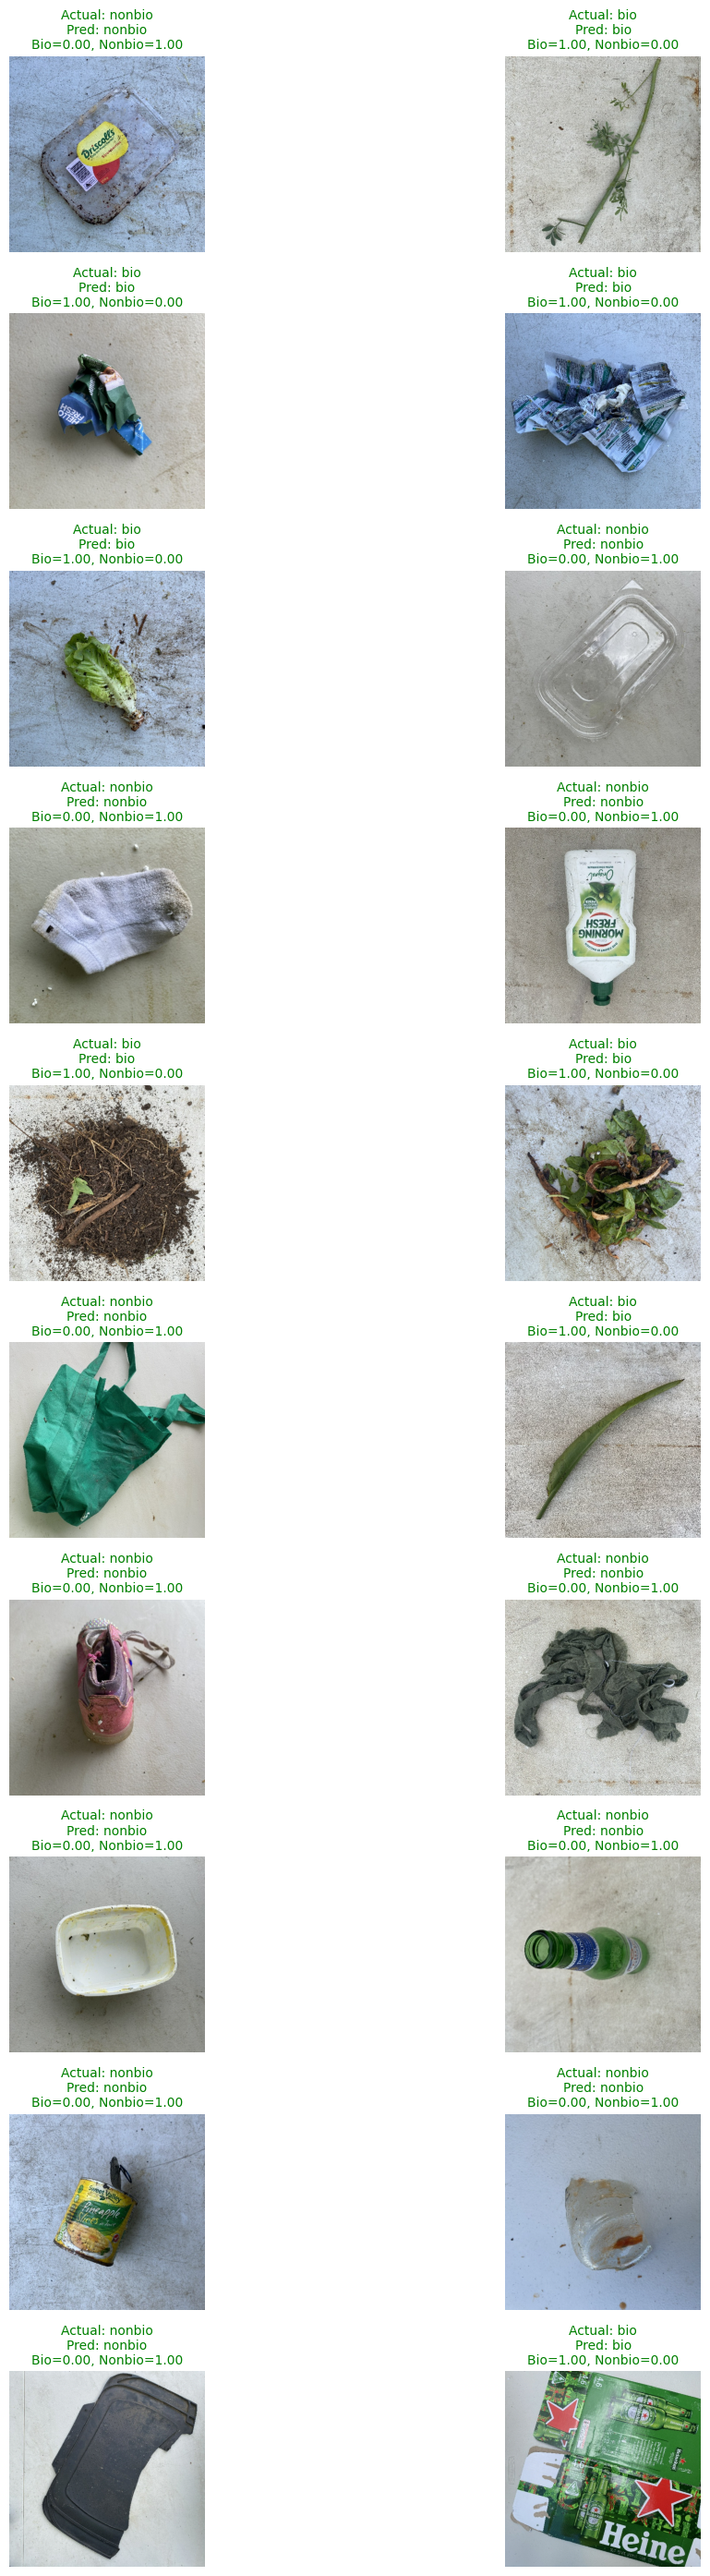


🎉 SUMMARY
Accuracy on 20 images: 1.0
True: ['nonbio', 'bio', 'bio', 'bio', 'bio', 'nonbio', 'nonbio', 'nonbio', 'bio', 'bio', 'nonbio', 'bio', 'nonbio', 'nonbio', 'nonbio', 'nonbio', 'nonbio', 'nonbio', 'nonbio', 'bio']
Pred: ['nonbio', 'bio', 'bio', 'bio', 'bio', 'nonbio', 'nonbio', 'nonbio', 'bio', 'bio', 'nonbio', 'bio', 'nonbio', 'nonbio', 'nonbio', 'nonbio', 'nonbio', 'nonbio', 'nonbio', 'bio']


In [ ]:
import random
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from sklearn.metrics import accuracy_score
from pathlib import Path
import matplotlib.pyplot as plt

# ---------------------------------------------------
# Load best model
# ---------------------------------------------------
ckpt = torch.load("/content/best_model.pth", map_location=DEVICE)

model = timm.create_model(
    "tf_efficientnetv2_s_in21k",
    pretrained=False,
    num_classes=2
)
model.load_state_dict(ckpt["model_state"])
model.to(DEVICE)
model.eval()

classes = ckpt["classes"]
print("Loaded model with classes:", classes)

# ---------------------------------------------------
# Inference transform
# ---------------------------------------------------
infer_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# ---------------------------------------------------
# Select 20 random images
# ---------------------------------------------------
VAL_ROOT = Path("/content/realwaste_binary/val")
all_imgs = list(VAL_ROOT.rglob("*.jpg")) + list(VAL_ROOT.rglob("*.png"))
random.shuffle(all_imgs)
test_imgs = all_imgs[:20]

print(f"Testing on {len(test_imgs)} random images...\n")

y_true = []
y_pred = []

# ---------------------------------------------------
# Plot settings
# ---------------------------------------------------
plt.figure(figsize=(14, 28))   # Tall grid

for i, path in enumerate(test_imgs):
    img = Image.open(path).convert("RGB")
    tensor = infer_tf(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad(), torch.cuda.amp.autocast():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred_idx = int(np.argmax(probs))
        pred_label = classes[pred_idx]

    actual_label = path.parent.name

    y_true.append(actual_label)
    y_pred.append(pred_label)

    # ---------------------------------------------------
    # SHOW IMAGE + PREDICTION TEXT
    # ---------------------------------------------------
    plt.subplot(10, 2, i+1)  # 20 images = grid 10x2
    plt.imshow(img)
    plt.axis("off")

    title_color = "green" if actual_label == pred_label else "red"

    plt.title(
        f"Actual: {actual_label}\nPred: {pred_label}\n"
        f"Bio={probs[classes.index('bio')]:.2f}, "
        f"Nonbio={probs[classes.index('nonbio')]:.2f}",
        color=title_color,
        fontsize=10
    )

plt.tight_layout()
plt.show()

# ---------------------------------------------------
# Summary
# ---------------------------------------------------
acc = accuracy_score(y_true, y_pred)
print("\n🎉 SUMMARY")
print("Accuracy on 20 images:", round(acc, 4))
print("True:", y_true)
print("Pred:", y_pred)
